In [3]:
# anomaly_training.py
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn2pmml import PMMLPipeline, sklearn2pmml
import matplotlib.pyplot as plt

In [2]:
!pip3 install sklearn2pmml

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 2.8 MB/s  0:00:02 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [sklearn2pmml]

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [4]:
# --- 1. Load Dataset ---
df = pd.read_csv("health_fitness_dataset.csv")

In [5]:
# Inspect the structure
print(df.head())

   participant_id        date  age gender  height_cm  weight_kg  \
0               1  2024-01-01   56      F      165.3       53.7   
1               1  2024-01-04   56      F      165.3       53.9   
2               1  2024-01-05   56      F      165.3       54.2   
3               1  2024-01-07   56      F      165.3       54.4   
4               1  2024-01-09   56      F      165.3       54.7   

     activity_type  duration_minutes intensity  calories_burned  ...  \
0          Dancing                41       Low              3.3  ...   
1         Swimming                28       Low              2.9  ...   
2         Swimming                21    Medium              2.6  ...   
3  Weight Training                99    Medium             10.7  ...   
4         Swimming               100    Medium             12.7  ...   

   stress_level  daily_steps  hydration_level   bmi  resting_heart_rate  \
0             3         7128              1.5  19.6                69.5   
1             

In [8]:
# --- 2. Select Relevant Features ---
features = [
    "age", "weight_kg", "height_cm",
    "avg_heart_rate", "daily_steps", "calories_burned", "hours_sleep"
]

df = df[features]

In [9]:
# --- 3. Handle Missing or Abnormal Values ---
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

In [11]:
# Remove biologically impossible values
df = df[(df["age"] > 10) & (df["age"] < 90)]
df = df[(df["avg_heart_rate"] > 30) & (df["avg_heart_rate"] < 220)]
df = df[(df["daily_steps"] > 0) & (df["calories_burned"] > 0)]

In [12]:
# --- 4. Scale & Train IsolationForest ---
pipeline = PMMLPipeline([
    ("scaler", StandardScaler()),
    ("isolation_forest", IsolationForest(
        n_estimators=200,
        contamination=0.05,   # expected % of anomalies
        random_state=42,
        max_samples="auto"
    ))
])

X = df.values

print("Training Isolation Forest on FitLife data...")
pipeline.fit(X)

Training Isolation Forest on FitLife data...


/Users/aruuketurgunbaeva/Library/Python/3.9/lib/python/site-packages/sklearn2pmml/pipeline/__init__.py:69: UserWarning: X is missing feature names. The reproducibility of predictions between Scikit-Learn and PMML can not be guaranteed
  warnings.warn("X is missing feature names. The reproducibility of predictions between Scikit-Learn and PMML can not be guaranteed")


PMMLPipeline(steps=[('scaler', StandardScaler()),
       ('isolation_forest', IsolationForest(contamination=0.05, n_estimators=200, random_state=42))])

In [13]:
# --- 5. Get Scores for Sanity Check ---
scores = pipeline.predict(X)  # -1 = anomaly, 1 = normal
anomaly_scores = pipeline.named_steps['isolation_forest'].decision_function(X)


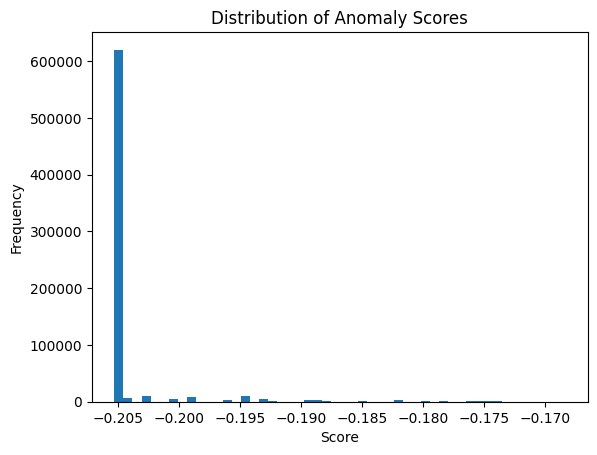

Fraction of anomalies: 5.00%


In [14]:
# Visual check (optional)
plt.hist(anomaly_scores, bins=50)
plt.title("Distribution of Anomaly Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

print(f"Fraction of anomalies: {(scores == -1).mean():.2%}")

In [15]:
# --- 6. Save Model as PMML ---
sklearn2pmml(pipeline, "anomaly_model.pmml", with_repr=True)
print("✅ Model saved as anomaly_model.pmml")

✅ Model saved as anomaly_model.pmml


   age  weight_kg  avg_heart_rate  daily_steps  calories_burned  hours_sleep  \
0   30         70              80         7000             2300            7   
1   45         85             105         1500             1200            5   
2   25         60             130          500              800            3   

   prediction     score  
0          -1 -0.089837  
1          -1 -0.118608  
2          -1 -0.138791  


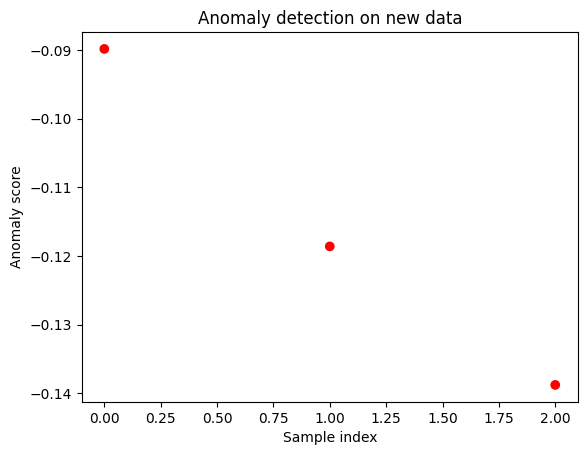

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# --- 1. Обучение на тренировочных данных ---
df = pd.read_csv("health_fitness_dataset.csv")
X = df[['age', 'weight_kg', 'avg_heart_rate', 'daily_steps', 'calories_burned', 'hours_sleep']]

model = make_pipeline(StandardScaler(), IsolationForest(contamination=0.05, random_state=42))
model.fit(X)

# --- 2. Предсказание на новых ---
X_new = pd.DataFrame([
    # Нормальные значения
    {'age': 30, 'weight_kg': 70, 'avg_heart_rate': 80, 'daily_steps': 7000, 'calories_burned': 2300, 'hours_sleep': 7},

    # Немного выбиваются (могут быть на грани)
    {'age': 45, 'weight_kg': 85, 'avg_heart_rate': 105, 'daily_steps': 1500, 'calories_burned': 1200, 'hours_sleep': 5},

    # Явно аномальные
    {'age': 25, 'weight_kg': 60, 'avg_heart_rate': 130, 'daily_steps': 500, 'calories_burned': 800, 'hours_sleep': 3},
])
pred = model.predict(X_new)
scores = model[-1].decision_function(model[0].transform(X_new))

X_new['prediction'] = pred
X_new['score'] = scores
print(X_new)

# --- 3. Визуализация ---
colors = ['red' if p == -1 else 'blue' for p in pred]
plt.scatter(range(len(scores)), scores, c=colors)
plt.title("Anomaly detection on new data")
plt.xlabel("Sample index")
plt.ylabel("Anomaly score")
plt.show()
